In [1]:
# Dependencies
from Main.framework import Value
from Main.neuralnet import Neuron, Layer, MLP
import random

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import yfinance as yf
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
np.random.seed(42)
random.seed(42)

In [2]:
# Initialize a model
model = MLP(5, [18,18, 1])  # 2-layer mlp
print("Number of parameters:", len(model.parameters()))

Number of parameters: 469


In [3]:
# Extract Data

nifty = yf.Ticker("^NSEI")
nifty = nifty.history(period="max")

nifty.index = nifty.index.date
nifty.rename_axis('Date', inplace=True)

nifty.index = nifty.index.astype('datetime64[ns]')
nifty = nifty.drop(columns=['Dividends','Stock Splits'])

nifty['Tommorrow'] = nifty['Close'].shift(-1)
nifty.dropna(inplace=True)
nifty['Target'] = (nifty['Tommorrow'] > nifty['Close']).astype(int)

nifty = nifty[nifty['Volume']>0]

nifty

,Open,High,Low,Close,Volume,Tommorrow,Target
Date,,,,,,,
2013-01-21,6085.750000,6094.350098,6065.100098,6082.299805,130900,6048.500000,0
2013-01-22,6080.149902,6101.299805,6040.500000,6048.500000,129000,6054.299805,1
2013-01-23,6052.850098,6069.799805,6021.149902,6054.299805,137000,6019.350098,0
2013-01-24,6046.200195,6065.299805,6007.850098,6019.350098,185200,6074.649902,1
2013-01-25,6024.500000,6080.549805,6014.450195,6074.649902,147600,6074.799805,1
...,...,...,...,...,...,...,...
2024-08-08,24248.550781,24340.500000,24079.699219,24117.000000,311900,24367.500000,1
2024-08-09,24386.849609,24419.750000,24311.199219,24367.500000,215100,24347.000000,0
2024-08-12,24320.050781,24472.800781,24212.099609,24347.000000,279900,24139.000000,0


In [4]:
X, y = nifty.iloc[:-100,:-2].values, nifty.iloc[:-100,-1].values
Xtest, ytest = nifty.iloc[-100:,:-2].values, nifty.iloc[-100:,-1].values

In [5]:
# loss function
def loss(batch_size=None):
    # Inline DataLoader
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # Forward the model to get scores
    scores = list(map(model, inputs))

    # SVM "max-margin" loss
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # Calculate accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


In [6]:
# Calculate initial loss and accuracy
total_loss, acc = loss()
print(f"Initial loss: {total_loss.data:.4f}, accuracy: {acc * 100:.2f}%")

Initial loss: 43728.3109, accuracy: 46.07%


In [7]:
# Initialize DataFrame to store optimization details
opt_details = pd.DataFrame(columns=['Loss', 'Accuracy'])
    
def optimize(details, n: int = 120, batch_size = 16):
    # Optimization loop
    for k in range(n):
        # Forward
        total_loss, acc = loss(batch_size) # Adjust batch size based on sample and memory constraints

        # Backward
        model.zero_grad()
        total_loss.backward()

        # Update (SGD)
        learning_rate = 1.0 - 0.9 * k / 100
        for p in model.parameters():
            p.data -= learning_rate * p.grad

        # Store details in DataFrame
        details.loc[len(details.index)] = { 'Loss': total_loss.data, 'Accuracy': acc}
        
    details.index += 1

optimize(opt_details)

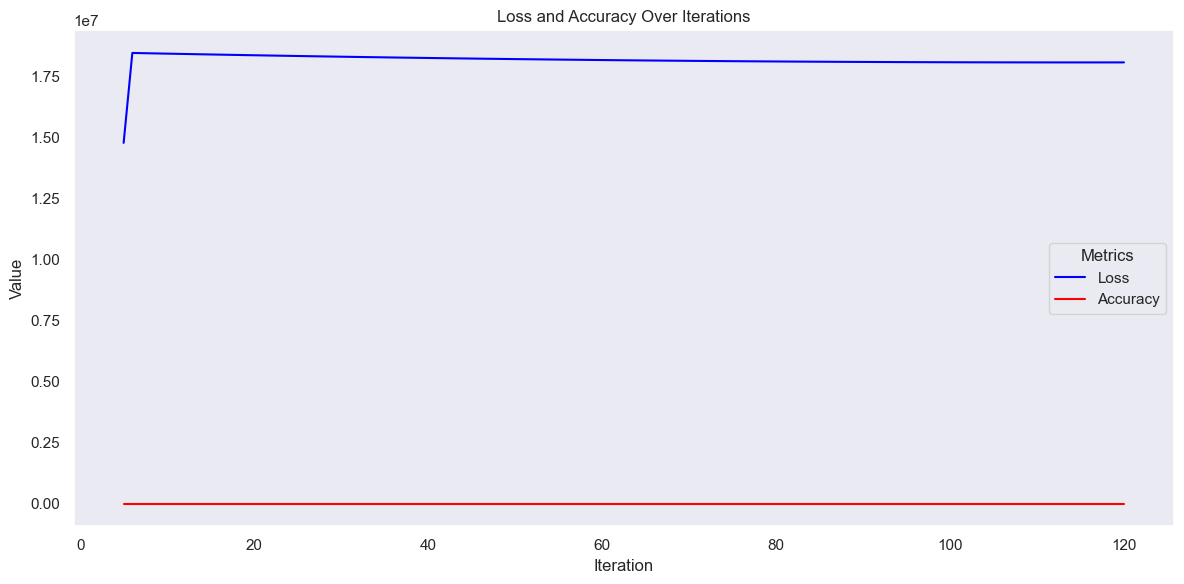

In [8]:
# Visualize Training process
def viz_training(details):
    
    # Smooth the curves using a rolling mean
    details['Loss_Smooth'] = details['Loss'].rolling(window=5).mean()
    details['Accuracy_Smooth'] = details['Accuracy'].rolling(window=5).mean()

    # Visualization
    plt.figure(figsize=(12, 6))

    # Set the style
    sns.set(style="dark", palette="Spectral")

    # Create line plots for Loss and Accuracy
    sns.lineplot(data=details, x=details.index, y='Loss_Smooth', color='b', label='Loss')
    sns.lineplot(data=details, x=details.index, y='Accuracy_Smooth', color='r', label='Accuracy')

    plt.title('Loss and Accuracy Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.legend(title='Metrics')

    plt.tight_layout()
    plt.show()

viz_training(opt_details)


In [9]:
# Predictions on Test and Train data
y_pred_test = [1 if model([Value(xi[0]), Value(xi[1])]).data > 0 else -1 for xi in Xtest]
y_pred_train = [1 if model([Value(xi[0]), Value(xi[1])]).data > 0 else -1 for xi in X]

In [10]:
def plot_metrics(y_train, y_pred_train, y_test, y_pred_test):
    # Calculate metrics for training data
    precision_train = precision_score(y_train, y_pred_train) * 100
    recall_train = recall_score(y_train, y_pred_train) * 100
    f1_train = f1_score(y_train, y_pred_train)
    
    # Calculate metrics for test data
    precision_test = precision_score(y_test, y_pred_test) * 100
    recall_test = recall_score(y_test, y_pred_test) * 100
    f1_test = f1_score(y_test, y_pred_test)
    
    # Create a DataFrame to store the metrics
    metrics = {
        'KPI': ['Precision', 'Recall', 'F1 Score'],
        'Training Data': [precision_train, recall_train, f1_train],
        'Test Data': [precision_test, recall_test, f1_test]
    }
    
    metrics_df = pd.DataFrame(metrics).set_index('KPI')
    
    return metrics_df

metrics_df = plot_metrics(y, y_pred_train, ytest, y_pred_test)
metrics_df

,Training Data,Test Data
KPI,,
Precision,53.928440,57.000000
Recall,100.000000,100.000000
F1 Score,0.700695,0.726115


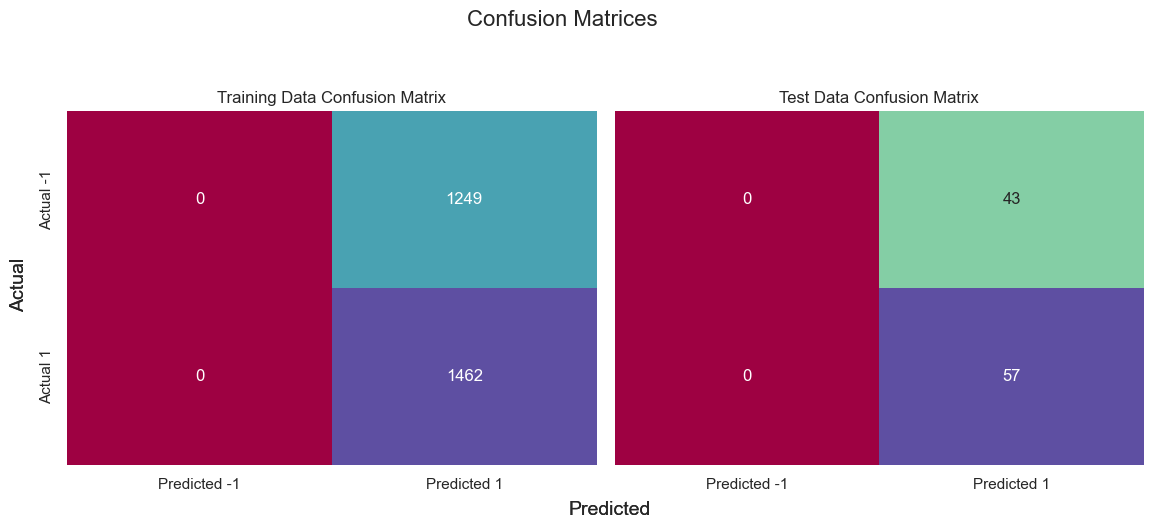

In [11]:
def plot_matrix(y_true, y_pred, title, ax, fig, fontsize=12):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Spectral', cbar=False,
                xticklabels=['Predicted -1', 'Predicted 1'], yticklabels=['Actual -1', 'Actual 1'], 
                ax=ax, annot_kws={"size": fontsize})
    ax.set_title(f'{title} Confusion Matrix', fontsize=fontsize)
    
    # Set shared axis labels
    fig.text(0.54, 0.04, 'Predicted', ha='center', fontsize=14)
    fig.text(0.04, 0.5, 'Actual', va='center', rotation='vertical', fontsize=14)

# Plot confusion matrices side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

plot_matrix(y, y_pred_train, "Training Data", axs[0], fig)
plot_matrix(ytest, y_pred_test, "Test Data", axs[1], fig)

# Set the overall title for the plot
fig.suptitle('Confusion Matrices', fontsize=16, y=1.05)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()